In [22]:
#this notebook includes the code for analyzing gene expression profile data of neoblastomas

#one of the first steps of any data analysis is to load and clean the data

#first lets load up both of the data
#we will need pandas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clinical_data=pd.read_csv('clinical_data_for_assessment_final.csv')
allProbRaw=pd.read_csv('allProbIntensities_rawdata_final.csv')

#lets set the id as index and then describe the statistics of the clinical data
clinical_data = clinical_data.set_index('ID')

clinical_data.describe(include='all')

#print(clinical_data)
#print(allProbRaw)

#lets rename a few columns in the allprobintens file
#these two are for the gene and prob id's
allProbRaw=allProbRaw.rename({"GeneSymbols":"gene_id"}, axis=1)
allProbRaw=allProbRaw.rename({"Reporter.Identifier":"probe_id"}, axis=1)


#it looks like there are some similarities of both the files
#the IDs in the clinical data are the columns in the prob intensity file
#we see that some of the ages are significantly over 100  some are 0 
#the mycn status says amp in some of the rows instead of number
#inss stage does contain some strings

#in the intensities file some of the cells in the csv file contain N/As which we will have to remove or edit 
#these are some of the examples of the data in which we will need to clean, impute, etc to make sure we can ensure a non biased analysis

allProbRaw


,probe_id,gene_id,ICGC_001_TCGA,ICGC_002_TCGA,ICGC_003_TCGA,ICGC_004,ICGC_005,ICGC_006,ICGC_007,ICGC_008,...,ICGC_489,ICGC_490,ICGC_491_TCGA,ICGC_492,ICGC_493,ICGC_494_TCGA,ICGC_495,ICGC_496_TCGA,ICGC_497,ICGC_498
0,NaN,NaN,14.99,14.94,12.48,14.63,11.89,15.09,13.07,12.00,...,13.62,13.03,14.98,13.36,13.90,13.00,13.79,14.70,14.03,12.31
1,27262.0,NaN,9.20,10.41,9.27,8.83,NaN,10.33,9.62,8.72,...,6.26,5.93,6.97,5.99,7.62,7.76,8.56,7.74,7.57,NaN
2,3180.0,NaN,5.06,5.26,6.45,2.89,2.00,4.80,3.05,6.39,...,0.93,0.58,1.26,1.38,3.49,2.07,2.26,2.29,NaN,2.54
3,41426.0,NaN,7.45,8.68,6.30,7.30,6.26,7.50,7.43,6.98,...,5.35,5.57,5.51,6.30,6.60,6.38,7.49,6.77,8.13,NaN
4,37033.0,NaN,6.74,6.63,6.75,6.20,6.57,6.01,6.78,4.80,...,4.58,4.61,3.54,4.55,4.20,7.16,7.07,5.07,6.28,6.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44703,22435.0,NaN,10.35,10.33,9.81,10.36,9.65,10.46,9.17,10.23,...,8.60,7.37,8.22,8.44,10.17,NaN,10.09,9.68,9.98,9.40
44704,17350.0,NaN,17.05,16.62,17.45,16.72,16.93,17.69,16.85,18.07,...,17.14,16.79,NaN,16.71,16.46,16.83,17.16,17.24,17.11,NaN
44705,28875.0,NaN,5.30,6.84,5.29,5.33,4.81,6.62,6.52,5.37,...,4.07,3.05,2.77,4.14,3.94,4.19,6.85,4.99,4.51,3.34
44706,8993.0,NaN,13.91,13.57,NaN,13.84,13.22,13.79,NaN,13.93,...,13.00,12.18,12.97,13.04,14.19,13.50,NaN,13.99,14.37,NaN


In [23]:
#now we can do cleaning of the intensity data file

#it was observed in the gene_id column and probe_id columns that there are both NaN's and blank strings
#since we cannot impute the data or take the mean/median (gene=biological reference, probe= unique probe id), we will need to remove the rows with these

#remove na and empty str from gene_id and just na from probe_id since there are no empty spaces in the data file in this column
prob_cleaned = allProbRaw[
allProbRaw['gene_id'].notna() &
allProbRaw['probe_id'].notna() &# remove NaNs
(allProbRaw['gene_id'].str.strip() != '') # removes empty space
]


#so let's set the gene_id as the index
prob_cleaned= prob_cleaned.set_index('gene_id')

prob_cleaned

#okay so now there are NaNs in the probe intensity samples (column names after probe id) have NaNs
#we will have to approach this differently since we cannot just outright delete the column for each

#lets do a sum on na values
prob_cleaned.isnull().sum()

#will need to clean the sample columns, there are a significant amount of NaNs 
#in order to do this we can impute the values using the median for all the NaN values in each column


#let's define the features to start the median imputation
#the features we need are the columns 1:end we can not include the first column since it is the probe id and we only want to impute the intensity values
sample_cols = prob_cleaned.columns[1:]

prob_cleaned[sample_cols] = prob_cleaned[sample_cols].apply(lambda col: col.fillna(col.median()), axis=0)

prob_cleaned.isnull().sum()




probe_id         0
ICGC_001_TCGA    0
ICGC_002_TCGA    0
ICGC_003_TCGA    0
ICGC_004         0
                ..
ICGC_494_TCGA    0
ICGC_495         0
ICGC_496_TCGA    0
ICGC_497         0
ICGC_498         0
Length: 499, dtype: int64

In [24]:
#now we should look at the clinical file

#let's look at the columns to see if we need to rename
clinical_data

#let's rename a few columns
#clinico genetic subgroup
clinical_data=clinical_data.rename({"clinico.genetic.subgroup":"genetic_subgroup"},axis=1)
clinical_data=clinical_data.rename({"MYCN.status":"mycn_status"},axis=1)
clinical_data=clinical_data.rename({"INSS.Stage":"inss_stage"},axis=1)
clinical_data=clinical_data.rename({"DeathFromDisease":"death"},axis=1)

#now let's look if there are any na vals
clinical_data.isnull().sum()

#the age column has values that are 0 and some are in the thousands, typically age is in years however it could be in days, months, hours, etc
#looking at the research article that the data was obtained from, the age should be in months

#let's look at the statistics of the age colummn
clinical_data["Age"].describe()

#the max is 8983 months are 748 years which is impossible, the mean is 835 months which is 69 years.In table 1 from the paper the classification 
#separates the ages <18 months and >=18months. 
#Ages above 240 months (20 years) are excluded based on clinical expectations for neuroblastoma
#greater than 95% of neuroblastomas are diagnosed before the age of 10 years old

clinical_data_cleaned = clinical_data[clinical_data['Age'] <= 240]

#clinical_data_cleaned["Age"].describe()

clinical_data_cleaned

#so now let's convert some of the data to numerical values 
# we can convert gender to binary or numbers so male is 1 and female is 0

clinical_data_cleaned["Gender"] = clinical_data_cleaned["Gender"].replace({'M': 1, 'F': 0})

#then convert mycn_status amp to 1 and 1 to zero, mycn is a gene and making the amplified rows 1 and 1 equal to 0 makes it easier for identification
#more information would be needed to confirm that amp is the amplified mycn gene and 1 is not amplified

clinical_data_cleaned["mycn_status"]=clinical_data_cleaned["mycn_status"].replace({'Amp':1, 1:0})

#next let's look at the high risk column, we should make high risk a 1 and low risk a 0
clinical_data_cleaned["HighRisk"]=clinical_data_cleaned["HighRisk"].replace({'HR':1,'LR':0})

#inss stage should be fine as it is (1,2A/B,3,4,4s) and progression, death as well since these are 0 and 1


/tmp/ipykernel_13/2737959397.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_data_cleaned["Gender"] = clinical_data_cleaned["Gender"].replace({'M': 1, 'F': 0})
/tmp/ipykernel_13/2737959397.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_data_cleaned["mycn_status"]=clinical_data_cleaned["mycn_status"].replace({'Amp':1, 1:0})
/tmp/ipykernel_13/2737959397.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

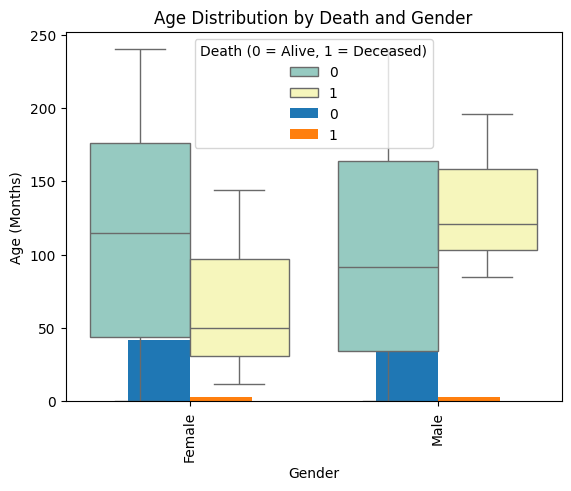

0


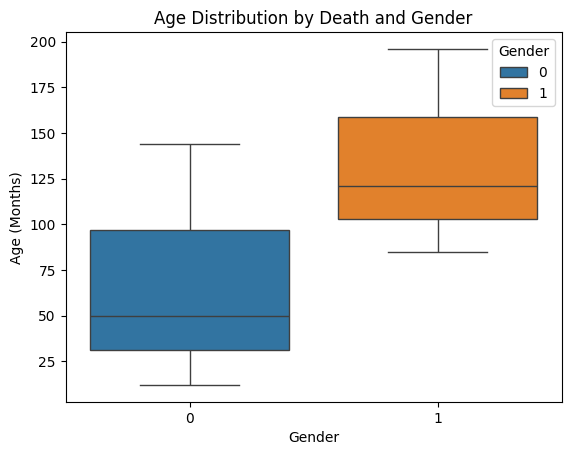

,Gender,Age,HighRisk,Progression,death
count,6.000000,6.000000,6.000000,6.0,6.0
mean,0.500000,101.333333,0.500000,1.0,1.0
std,0.547723,66.409839,0.547723,0.0,0.0
min,0.000000,12.000000,0.000000,1.0,1.0
25%,0.000000,58.750000,0.000000,1.0,1.0
50%,0.500000,103.000000,0.500000,1.0,1.0
75%,1.000000,138.250000,1.000000,1.0,1.0
max,1.000000,196.000000,1.000000,1.0,1.0


In [25]:
#we should now look at the data from the clinical data 

clinical_data_cleaned.describe()

#let's first compare the deaths vs gender

gender_vs_dth = pd.crosstab(clinical_data_cleaned['Gender'], clinical_data_cleaned['death'])
gender_vs_dth.index = ["Female", "Male"]
gender_vs_dth.plot.bar()

#the deaths are very similar in number so this does not seem significant
#now we will observe age vs deaths

sns.boxplot(
    x="Gender",
    y="Age",
    hue="death",
    data=clinical_data_cleaned,
    palette="Set3"
)
plt.title("Age Distribution by Death and Gender")
plt.xlabel("Gender")
plt.ylabel("Age (Months)")
plt.legend(title="Death (0 = Alive, 1 = Deceased)")
plt.show()

#it seems that the deaths for females occur earlier at 75 to 100 months while males occur aroud 100 to 150.
#also there are earlier deaths in both the males and females this can be the 0 month aged samples
#lets look if there are deaths that are at 0 months of age 

print(len(clinical_data_cleaned.loc[(clinical_data_cleaned['death'] == 1) & (clinical_data_cleaned['Age'] <= 1)]))

#okay now from the graph we can see that there is a cutoff of where a majority of the deaths start. 
#we can establish a range of deaths >= to 25 based on the chart in which the majority of the deaths start at around >=75

clinical_data_cleaned_dth = clinical_data_cleaned[clinical_data_cleaned['Age'] >= 25]

# #let's create a dataset with less than or equal to 25 months just in case for later analysis
# clinical_data_cleaned_dth_yg = clinical_data_cleaned[clinical_data_cleaned['Age'] <= 25 & clinical_data_cleaned['death'] > 0]

clinical_data_cleaned_dth = clinical_data_cleaned[clinical_data_cleaned['death'] > 0]

sns.boxplot(
    x="Gender",
    y="Age",
    data=clinical_data_cleaned_dth,
    hue="Gender"
)
plt.title("Age Distribution by Death and Gender")
plt.xlabel("Gender")
plt.ylabel("Age (Months)")
plt.show()

#now we have removed the lower month deaths we can see a clearer separation of age, gender, and death. 
clinical_data_cleaned_dth.describe()


In [26]:

#since there is a separation of male and female age vs deaths, we can look at the mycn status, high risk, progression in the deaths 

print(clinical_data_cleaned_dth['mycn_status'].unique())
print(clinical_data_cleaned_dth['HighRisk'].unique())
print(clinical_data_cleaned_dth['Progression'].unique())

#since all the deaths in the female and male samples have an amplified mycn ==1 we will assume that and drop the feature
clinical_data_cleaned_dth = clinical_data_cleaned_dth.drop(columns=['mycn_status'])
#we can also drop the high risk column as well
clinical_data_cleaned_dth = clinical_data_cleaned_dth.drop(columns=['HighRisk'])
#drop the progression column
clinical_data_cleaned_dth = clinical_data_cleaned_dth.drop(columns=['Progression'])
#we can separate the males vs females in the data frame

clinical_data_fem_dth = clinical_data_cleaned_dth[clinical_data_cleaned_dth['Gender'] != 1]
clinical_data_m_dth = clinical_data_cleaned_dth[clinical_data_cleaned_dth['Gender'] == 1]



[1 '1']
[1 0]
[1]


In [27]:
#lets look at the data now
print(clinical_data_m_dth)
print(clinical_data_fem_dth)

clinical_data_cleaned_dth.groupby(['Gender', 'genetic_subgroup']).size()
#it seems that there are differences between genders
#males gender 1 have a MNA subgroup with 4 or 4s advanced stages
#females have st4s genetic subgroups with only 4s advance stages
#however there are only 3 deaths so statistical inference power is limited
#moving forward let's do some analysis using these gender deaths and their correlated IDs in the probe intensities file to find certain genes related to them

          Gender    Age genetic_subgroup inss_stage  death
ID                                                        
ICGC_270       1  121.0              MNA          4      1
ICGC_314       1  196.0              MNA          4      1
ICGC_316       1   85.0              MNA         4S      1
          Gender    Age genetic_subgroup inss_stage  death
ID                                                        
ICGC_287       0   50.0             ST4S         4S      1
ICGC_289       0  144.0             ST4S         4S      1
ICGC_305       0   12.0             ST4S         4S      1


Gender  genetic_subgroup
0       ST4S                3
1       MNA                 3
dtype: int64

In [43]:

#let's create a list of IDs for each gender from the cleaned clinical data file
clinical_m_dth_ID = clinical_data_m_dth.index.tolist()

#lets rename them to tcga at the end
clinical_m_dth_cols = ['ICGC_270','ICGC_314','ICGC_316_TCGA','probe_id']

prob_cleaned_m_dth = prob_cleaned[clinical_m_dth_cols]

#now lets do the female deaths
clinical_f_dth_cols = ['ICGC_287','ICGC_289','ICGC_305','probe_id']

prob_cleaned_f_dth = prob_cleaned[clinical_f_dth_cols]

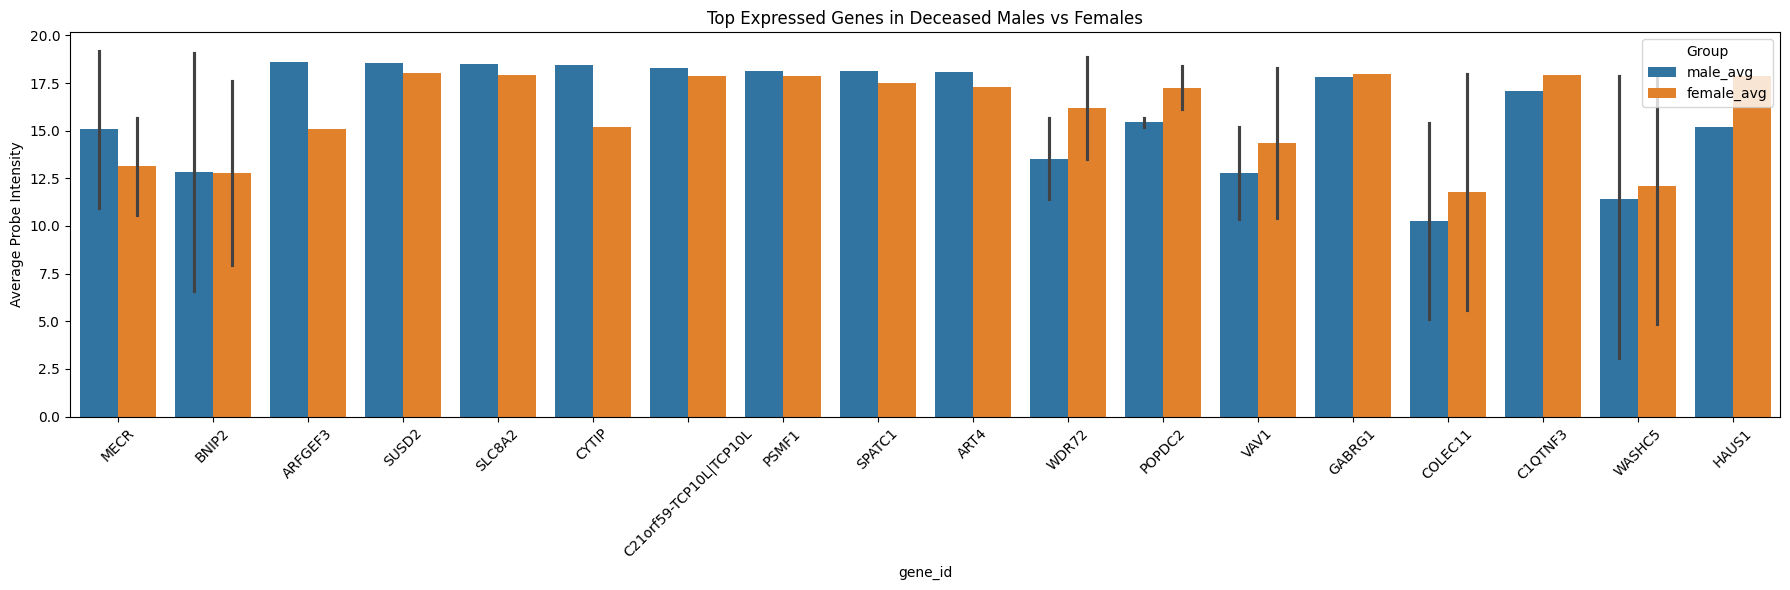

In [73]:
#lets now separate the male ad female ids and use this as a guide to visualize the distribution of intensities from the top 10 genes
male_ids = ['ICGC_270', 'ICGC_314', 'ICGC_316_TCGA']
female_ids = ['ICGC_287', 'ICGC_289', 'ICGC_305']

prob_cleaned['male_avg'] = prob_cleaned_m_dth[male_ids].mean(axis=1)
prob_cleaned['female_avg'] = prob_cleaned_f_dth[female_ids].mean(axis=1)

top_male_genes = prob_cleaned_m_dth['male_avg'].sort_values(ascending=False).head(10)
top_female_genes = prob_cleaned_f_dth['female_avg'].sort_values(ascending=False).head(10)

#combine the top genes
top_genes = pd.concat([top_male_genes, top_female_genes]).index.unique()

#subset to just those genes
df_top = prob_cleaned.loc[top_genes, ['male_avg', 'female_avg']].reset_index().melt(
    id_vars='gene_id', var_name='Group', value_name='Avg_Intensity'
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
sns.barplot(data=df_top, x='gene_id', y='Avg_Intensity', hue='Group')
plt.title("Top Expressed Genes in Deceased Males vs Females")
plt.ylabel("Average Probe Intensity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_13/109740634.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prob_cleaned_dths['mean_intensity'] = expression_only.mean(axis=1)


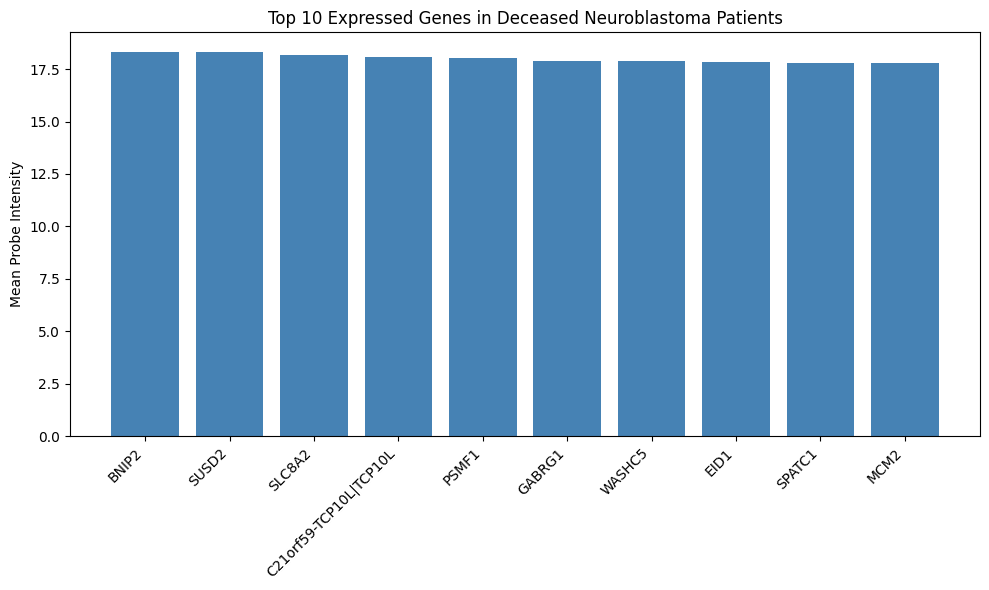

In [69]:
#the intensities of the top genes for males and females are very similar and do not indicate any clear trends, so we can just export the top expressed genes 
#in a table

clinical_dth_IDs = ['ICGC_270','ICGC_314','ICGC_316_TCGA','ICGC_287','ICGC_289','ICGC_305','probe_id']

prob_cleaned_dths = prob_cleaned[clinical_dth_IDs]

#now let's only include the top 10 expressed genes by probe intensity in a bar chart


#first remove 'probe_id' column (we're interested in expression intensities only)
expression_only = prob_cleaned_dths.drop(columns='probe_id')

#compuute average intensity across all 6 death samples
prob_cleaned_dths['mean_intensity'] = expression_only.mean(axis=1)

#now sort and get top 10 expressed genes
top_10_genes = prob_cleaned_dths.sort_values(by='mean_intensity', ascending=False).head(10)

#plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_genes.index, top_10_genes['mean_intensity'], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Probe Intensity")
plt.title("Top 10 Expressed Genes in Deceased Neuroblastoma Patients")
plt.tight_layout()
plt.show()

In [74]:
#lets export the top 10 genes to a csv file
top_10_genes[['mean_intensity']].to_csv("top_expressed_genes_table.csv")
